### Simulation

Even in the absence of an experimental setup, ``slmsuite`` is an ideal testbed for new holography algorithms and SLM techniques. Here, we demonstrate the basic simulation features of ``slmsuite`` to investigate the accuracy of the package's wavefront calibration routines.

In [1]:
# Header

%load_ext autoreload
%autoreload 2
%matplotlib inline

# Add slmsuite to the python path.
import sys, os
sys.path.append(os.path.join(os.getcwd(), '../../slmsuite'))

from slmsuite.hardware.cameraslms import FourierSLM

from slmsuite.holography import toolbox
from slmsuite.holography import analysis
from slmsuite.holography.algorithms import Hologram
from slmsuite.holography.algorithms import SpotHologram

import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import matplotlib as mpl

from mpl_toolkits.axes_grid1 import make_axes_locatable

mpl.rc('image', cmap='turbo')

C:\Users\cpanu\Documents\GitHub\slmsuite-examples\examples\../../slmsuite\slmsuite\hardware\cameraslms.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


#### Step 1: Build a simulated SLM

`SimulatedSLM` is a testbed for implementing physical non-idealities of spatial light modulators, including panel curvature (near-field phase distortions), cross-talk/mutual coupling, and non-uniform control value-to-phase shift transduction across the aperture. 

We start by building a `SimulatedSLM` with an arbitary flatness map (using `slmsuite`'s [Zernike functions](https://slmsuite.readthedocs.io/en/latest/_autosummary/slmsuite.holography.toolbox.phase.zernike_sum.html)) and elliptical source illumination.

In [2]:
from slmsuite.hardware.slms.simulated import SimulatedSLM

# SLM resolution in pixels
res = (640,480)

#Build an arbitrary flatness map 
dummy_slm = SimulatedSLM(res)
phase_offset = toolbox.phase.zernike_sum(dummy_slm,
    weights=(((2, 0),  7),       # Z_20
             ((2, 1), -8),       # Z_21
             ((3, 1),  9)),      # Z_31
    aperture="cropped")

#Normalize (relative to SLM size) Gaussian source standard deviations in (width, height) 
amp_profile=(0.4,0.3)

# The abberated SLM
slm = SimulatedSLM(res, phase_offset=phase_offset, amp_profile=amp_profile, bitdepth=12)

The ``phase_offset`` attribute of SimulatedSLM is independent of the SLM ``phase`` attribute, and is applied whenever ``phase`` is written to the SLM. We can therefore see the true phase profile of the SLM by plotting the ``display`` attribute. Similar logical follows for ``slm.amp_profile``.

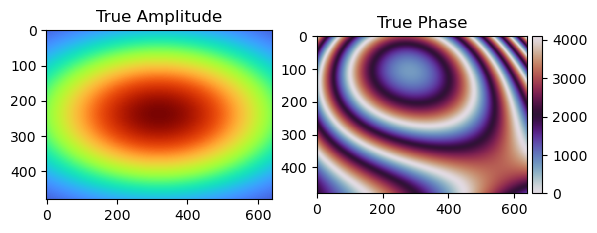

In [3]:
# Plot the true ampltude and phase 
fig, axs = plt.subplots(1,2)
axs[0].imshow(slm.amp_profile,clim=(0,1))
im = axs[1].imshow(slm.display,
               cmap=plt.get_cmap("twilight"),
               interpolation="none")
axs[0].set_title('True Amplitude')
axs[1].set_title('True Phase')

divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax);

#### Step 2: Build a simulated camera

``SimulatedCam`` computes the far-field of ``SimulatedSLM`` with desired imaging transformations.

In [4]:
from slmsuite.hardware.cameras.simulated import SimulatedCam

# A new resolution for the camera. The far-field calculation will be padded
# appropriately to account for the higher camera resolution.
cam_res = (1024,1024)

# Make the simulated camera computing images projected by `slm` with a slight imaging demagnification and rotation.
cam = SimulatedCam(cam_res, slm, mag=0.7, theta=np.pi/5, bitdepth=12) #np.pi/5

In [5]:
# TODO: fix incorrect padding implementation here (more padding -> magnification)

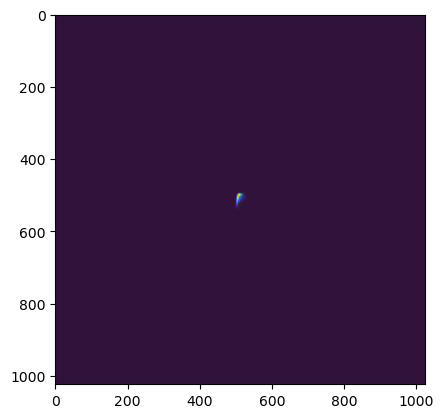

In [6]:
# Take a sample picture
img = cam.get_image(plot=False)
plt.imshow(img)

#### Step 3: Wavefront calibration

Now that we have simulated SLM/camera pair, we can use ``slmsuite``'s features normally, as if we had an experiment in hand! Here, we'll use simulation mode to check the accuracy of various wavefront calibration techniques.

  0%|          | 0/50 [00:00<?, ?it/s]

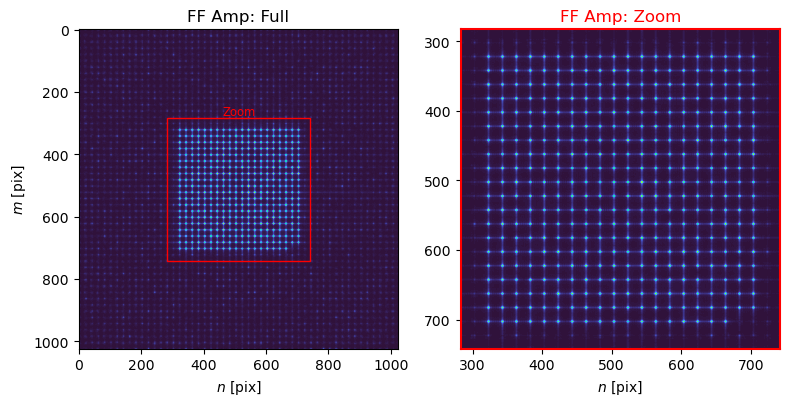

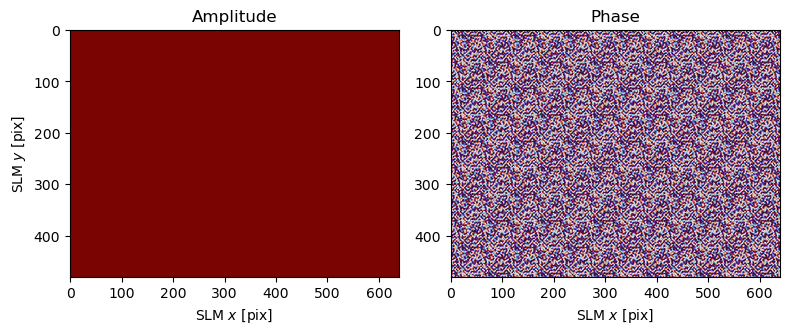

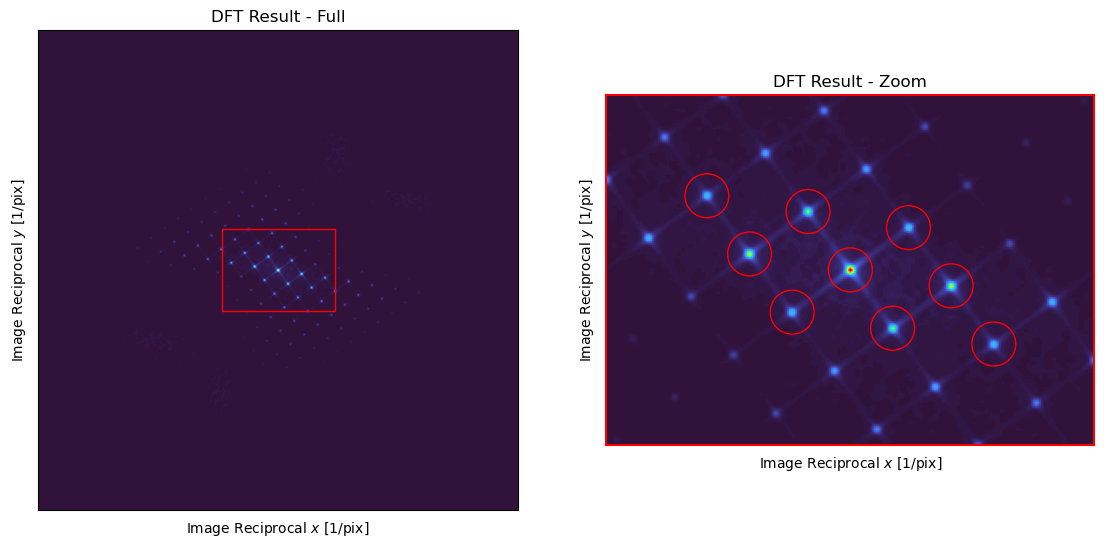

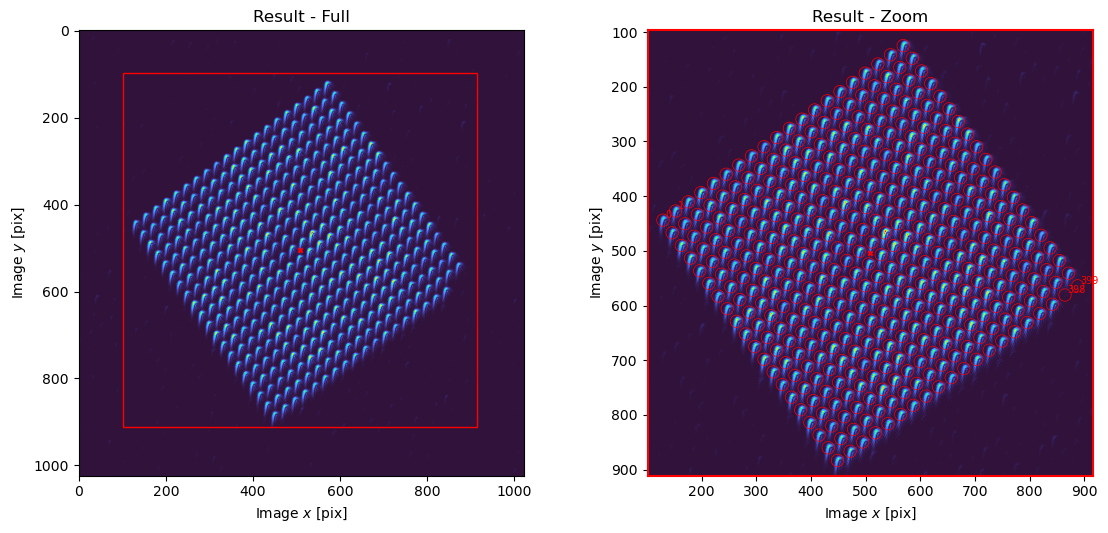

In [7]:
fs = FourierSLM(cam, slm)

fs.fourier_calibrate(
    array_shape=[20, 20],           # Size of the calibration grid (Nx, Ny) [knm]
    array_pitch=[20, 20],           # Pitch of the calibration grid (x, y) [knm]
    plot=True);

Once Fourier calibrated, we can wavefront calibrate. We'll use ``phase_steps=1`` first, which minimizes SLM writes by fitting the 2D imaged interference pattern between two superpixels. Lets test a superpixel...

Reset exposure to 2.00s; maximum image value = 0.
Reset exposure to 4.00s; maximum image value = 0.
Reset exposure to 8.00s; maximum image value = 0.
Reset exposure to 16.00s; maximum image value = 0.
Reset exposure to 32.00s; maximum image value = 0.
Reset exposure to 64.00s; maximum image value = 0.
Reset exposure to 128.00s; maximum image value = 0.
Reset exposure to 256.00s; maximum image value = 0.
Reset exposure to 512.00s; maximum image value = 0.
Reset exposure to 1024.00s; maximum image value = 0.
Reset exposure to 2048.00s; maximum image value = 0.
Reset exposure to 4096.00s; maximum image value = 0.
Reset exposure to 8192.00s; maximum image value = 0.
Reset exposure to 16384.00s; maximum image value = 0.
Reset exposure to 32768.00s; maximum image value = 0.
Reset exposure to 65536.00s; maximum image value = 1.
Reset exposure to 131072.00s; maximum image value = 2.
Reset exposure to 262144.00s; maximum image value = 5.
Reset exposure to 524288.00s; maximum image value = 11.
R

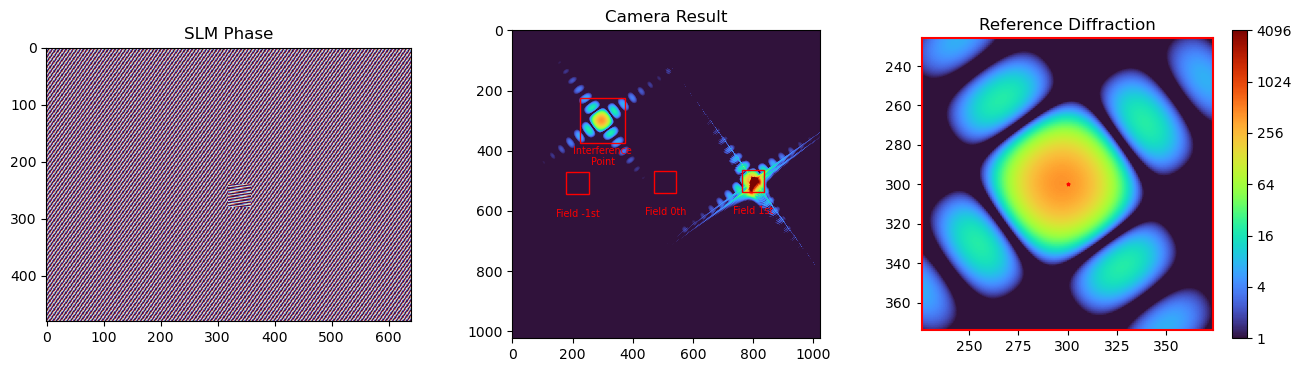

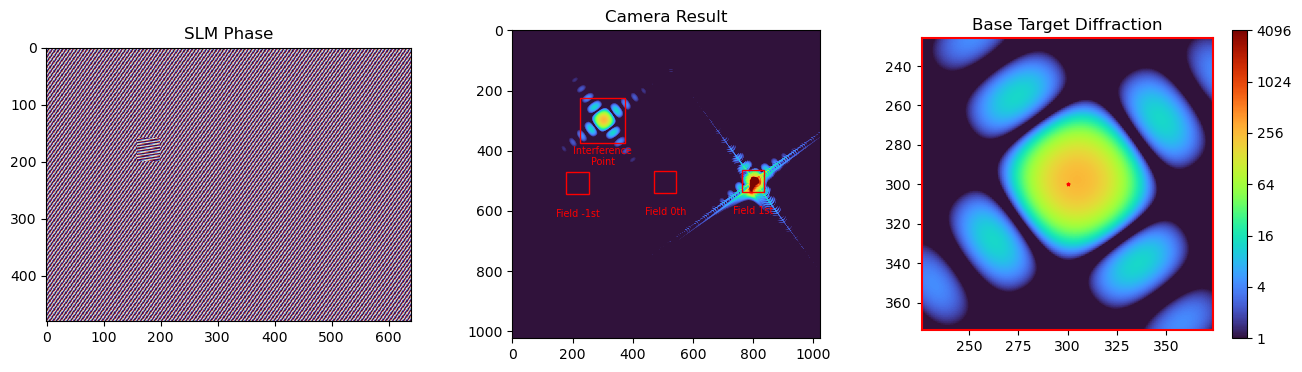

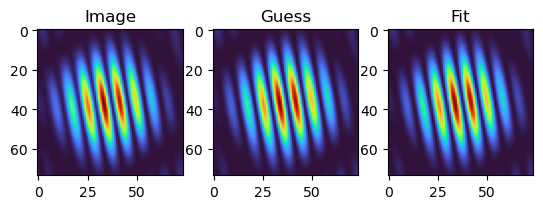

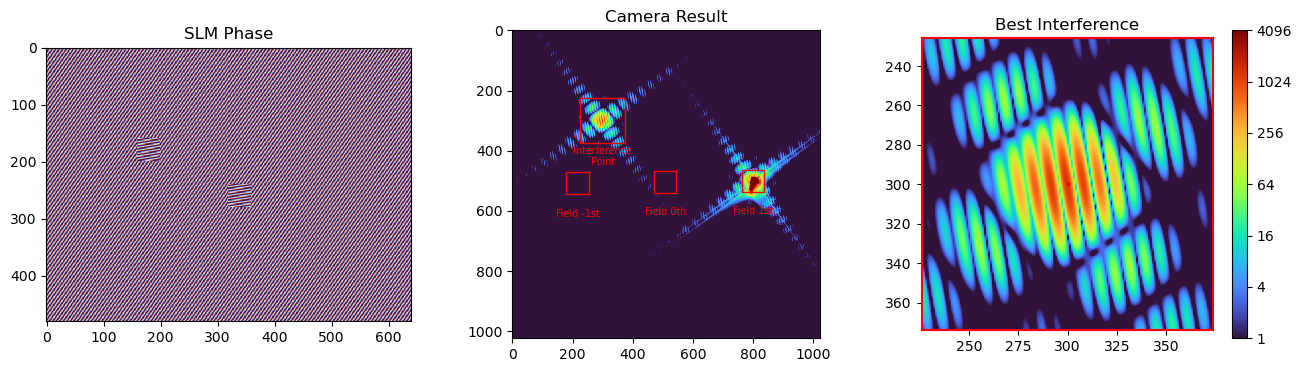

In [8]:
fs.wavefront_calibrate(
    interference_point=(300, 300),
    field_point=(800, 500),
    field_point_units="ij",
    superpixel_size=40,
    phase_steps=1,
    test_superpixel=(4,4),
    plot=True,
    autoexposure=True);

Looks good. We're doing it live!

In [9]:
fs.wavefront_calibrate(
    interference_point=(300, 300),
    field_point=(800, 500),
    field_point_units="ij",
    superpixel_size=40,
    phase_steps=1,
    plot=False,
    autoexposure=True);

Reset exposure to 36414631.89s; maximum image value = 819.
Reset exposure to 72829263.79s; maximum image value = 1638.
Reset exposure to 91036578.38s; maximum image value = 2047.


calibration:   0%|          | 0/192 [00:00<?, ?it/s]

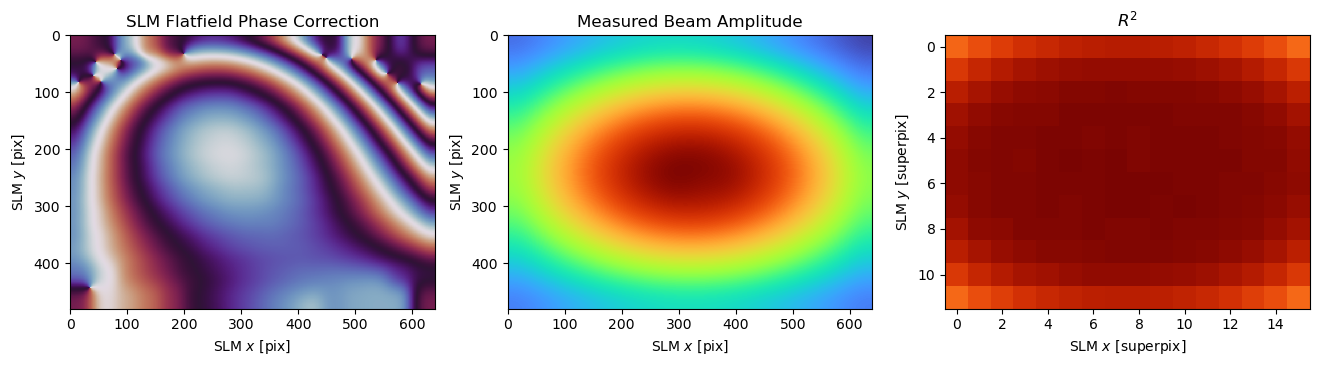

In [10]:
wavefront_cal = fs.process_wavefront_calibration(r2_threshold=.9, smooth=True, plot=True)

The phase pattern is smooth in the center but the fitting error increases around the panel edges where the illumination amplitude also drops off. The amplitude appears to be spot on (.. no pun intended ..). The real question is -- how does the computed flatness map compare to the true phase error?

Text(0.5, 1.0, 'Wavefront Error')

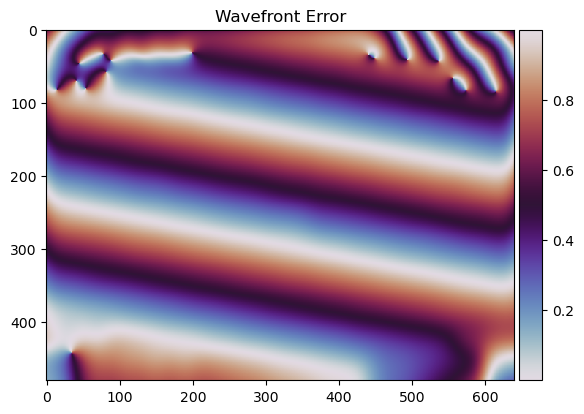

In [11]:
phase_corrected = np.mod(slm.phase_correction+slm.phase_offset, 2*np.pi)

fig, ax = plt.subplots(1,1)
im = ax.imshow(phase_corrected/(2*np.pi),
               cmap=plt.get_cmap("twilight"),
               interpolation="none")

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_title('Wavefront Error')

Qualitatively, e're left with (primarily) a residual blaze where the fitting was good. This makes sense, as any linear phase ramp in the true flatness map is effectively projected out (i.e. corrected) by **Fourier** calibration which calculates and compensates for the resulting spot translation. 

Quantiatively, how good did we do? To find out, let's try a hologram and compute some spot metrics.

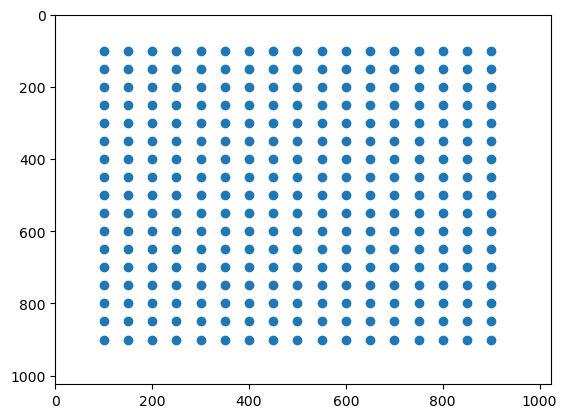

In [20]:
# Make the desired hologram
xlist = np.arange(100, 950, 50)                      # Get the coordinates for one edge
xgrid, ygrid = np.meshgrid(xlist, xlist)
square = np.vstack((xgrid.ravel(), ygrid.ravel()))                  # Make an array of points in a grid

plt.scatter(square[0,:], square[1,:])                               # Plot the points
plt.xlim([0, fs.cam.shape[1]]); plt.ylim([fs.cam.shape[0], 0])
plt.show()

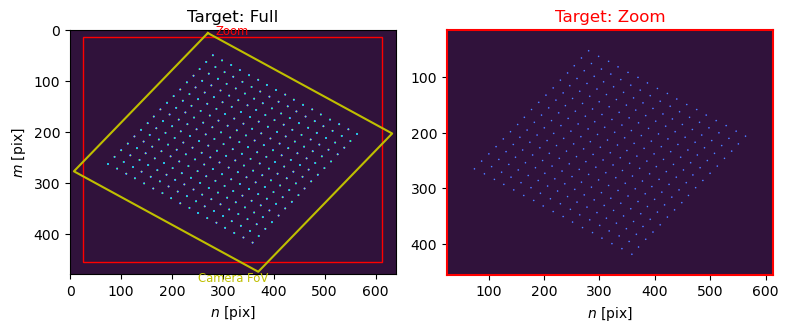

[array([ 25, 613], dtype=int64), array([ 14, 456], dtype=int64)]

In [21]:
hologram = SpotHologram(shape=slm.shape, spot_vectors=square, basis='ij', cameraslm=fs)
hologram.plot_farfield(hologram.target, title="Target")

In [22]:
hologram.optimize(
    'WGS-Kim',
    maxiter=20,
    feedback='experimental_spot',
    stat_groups=['computational_spot', 'experimental_spot'])

  0%|          | 0/20 [00:00<?, ?it/s]

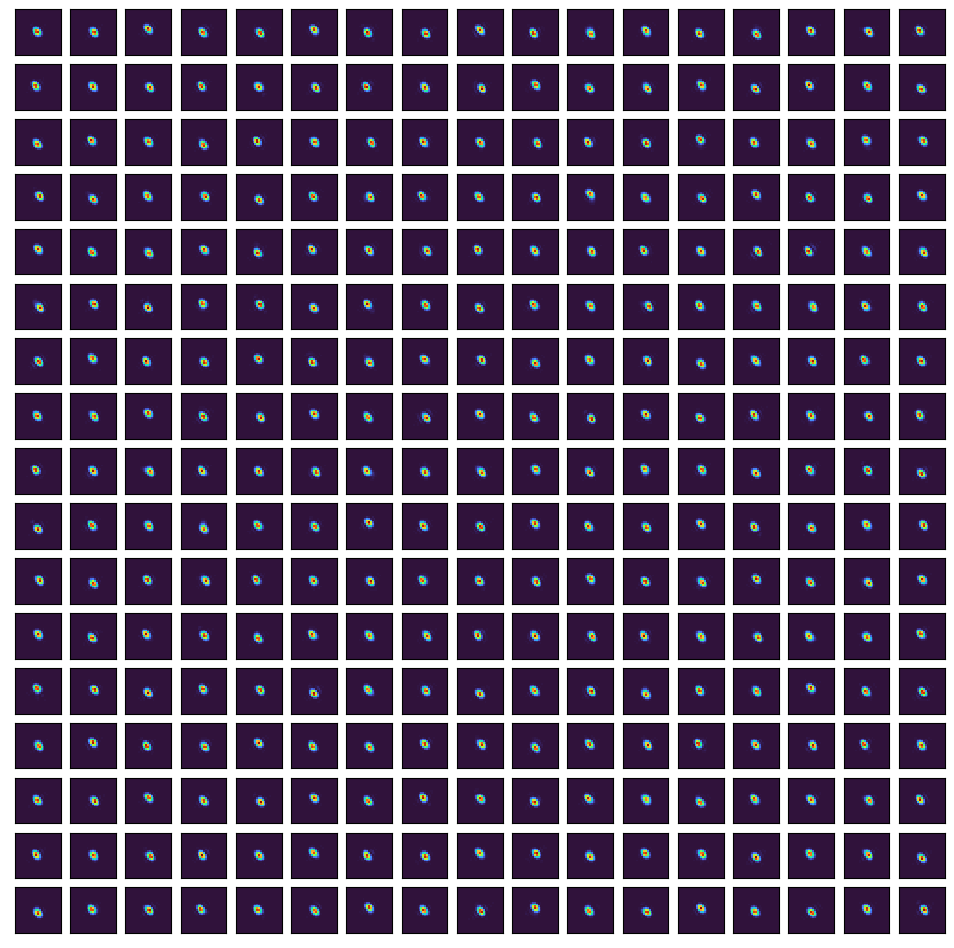

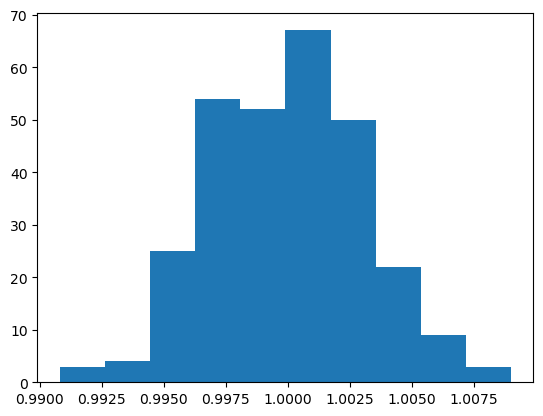

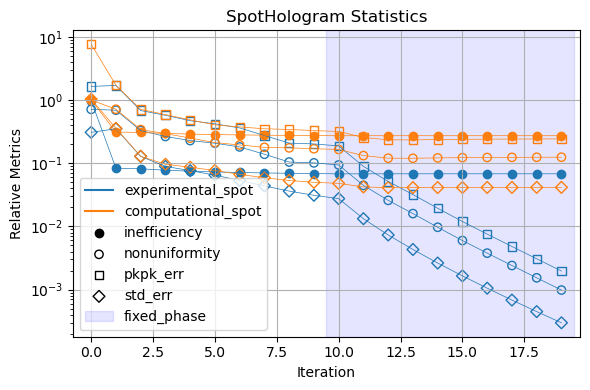

Spot center = (-0.006,0.008) +/- (0.458,0.619) px
Spot skew = 0.343 +/- 0.396 px


In [26]:
img = cam.get_image()                                        
subimages = analysis.take(img, square, 25)
analysis.take_plot(subimages)
power = analysis.image_normalization(np.array(subimages, dtype=np.float32))
plt.hist(power / np.mean(power)); plt.show()
hologram.plot_stats()

# Calculate a few statistics
pos = analysis.image_moment(subimages,moment=(1,0)), analysis.image_moment(subimages,moment=(0,1))
print(r"Spot center = (%1.3f,%1.3f) +/- (%1.3f,%1.3f) px"%(np.mean(pos[0]),np.mean(pos[1]),np.var(pos[0]),np.var(pos[1])))
shape = analysis.image_moment(subimages,moment=(1,1))
print(r"Spot skew = %1.3f +/- %1.3f px"%(np.mean(shape),np.var(shape)**0.5))

Peak-to-peak power uniformity is within 1\%. Lets compare the other stats to those generated using: 1) wavefront calibration using ``phase_steps>1``; and 2) perfect wavefront calibration.

In [27]:
#1) phase_steps=10
fs.wavefront_calibrate(
    interference_point=(300, 300),
    field_point=(800, 500),
    field_point_units="ij",
    superpixel_size=40,
    phase_steps=10,
    plot=False,
    autoexposure=True);

Reset exposure to 36414631.35s; maximum image value = 818.
Reset exposure to 72829262.70s; maximum image value = 1637.
Reset exposure to 91072193.62s; maximum image value = 2047.


calibration:   0%|          | 0/192 [00:00<?, ?it/s]

superpixel=(0,0):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(1,0):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(2,0):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(3,0):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(4,0):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(5,0):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(6,0):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(7,0):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(8,0):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(9,0):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(10,0):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(11,0):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(12,0):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(13,0):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(14,0):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(15,0):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(0,1):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(1,1):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(2,1):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(3,1):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(4,1):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(5,1):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(6,1):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(7,1):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(8,1):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(9,1):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(10,1):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(11,1):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(12,1):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(13,1):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(14,1):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(15,1):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(0,2):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(1,2):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(2,2):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(3,2):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(4,2):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(5,2):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(6,2):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(7,2):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(8,2):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(9,2):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(10,2):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(11,2):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(12,2):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(13,2):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(14,2):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(15,2):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(0,3):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(1,3):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(2,3):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(3,3):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(4,3):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(5,3):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(6,3):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(7,3):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(8,3):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(9,3):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(10,3):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(11,3):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(12,3):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(13,3):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(14,3):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(15,3):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(0,4):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(1,4):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(2,4):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(3,4):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(4,4):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(5,4):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(6,4):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(7,4):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(8,4):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(9,4):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(10,4):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(11,4):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(12,4):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(13,4):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(14,4):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(15,4):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(0,5):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(1,5):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(2,5):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(3,5):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(4,5):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(5,5):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(6,5):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(7,5):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(8,5):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(9,5):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(10,5):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(11,5):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(12,5):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(13,5):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(14,5):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(15,5):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(0,6):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(1,6):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(2,6):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(3,6):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(4,6):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(5,6):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(6,6):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(7,6):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(9,6):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(10,6):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(11,6):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(12,6):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(13,6):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(14,6):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(15,6):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(0,7):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(1,7):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(2,7):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(3,7):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(4,7):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(5,7):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(6,7):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(7,7):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(8,7):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(9,7):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(10,7):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(11,7):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(12,7):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(13,7):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(14,7):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(15,7):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(0,8):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(1,8):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(2,8):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(3,8):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(4,8):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(5,8):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(6,8):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(7,8):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(8,8):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(9,8):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(10,8):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(11,8):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(12,8):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(13,8):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(14,8):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(15,8):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(0,9):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(1,9):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(2,9):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(3,9):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(4,9):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(5,9):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(6,9):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(7,9):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(8,9):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(9,9):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(10,9):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(11,9):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(12,9):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(13,9):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(14,9):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(15,9):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(0,10):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(1,10):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(2,10):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(3,10):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(4,10):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(5,10):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(6,10):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(7,10):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(8,10):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(9,10):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(10,10):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(11,10):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(12,10):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(13,10):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(14,10):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(15,10):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(0,11):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(1,11):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(2,11):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(3,11):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(4,11):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(5,11):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(6,11):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(7,11):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(8,11):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(9,11):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(10,11):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(11,11):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(12,11):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(13,11):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(14,11):   0%|          | 0/10 [00:00<?, ?it/s]

superpixel=(15,11):   0%|          | 0/10 [00:00<?, ?it/s]

The calibration took ~2x longer (and with ~10x more calls to the SLM, which would actually dominate calibration time in an experiment); how did it perform?

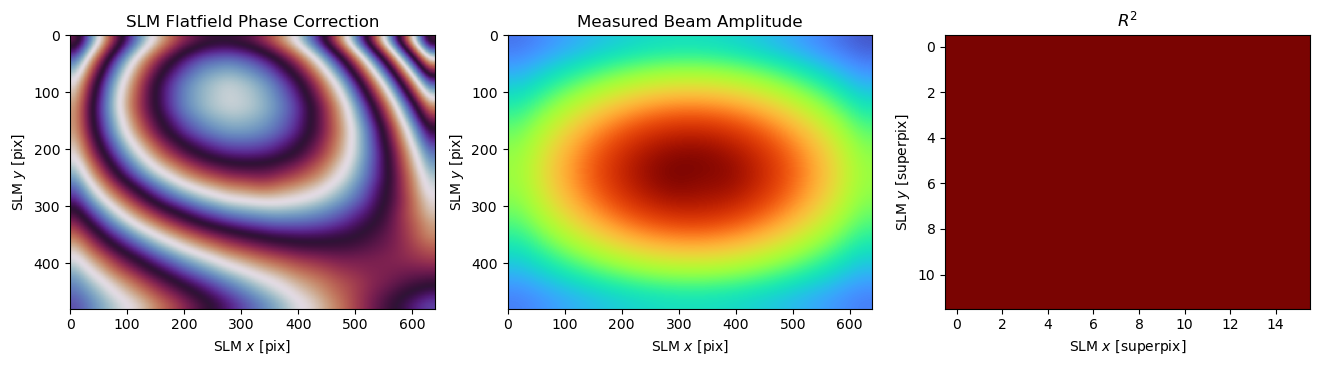

In [35]:
wavefront_cal = fs.process_wavefront_calibration(r2_threshold=.9, smooth=True, plot=True)

Does much better fitting mean much better spots?

In [36]:
#Redo Fourier cal
fs.fourier_calibrate(
    array_shape=[20, 20],           # Size of the calibration grid (Nx, Ny) [knm]
    array_pitch=[20, 20],           # Pitch of the calibration grid (x, y) [knm]
    plot=False)

  0%|          | 0/50 [00:00<?, ?it/s]

{'M': array([[1183.51128981,  859.85175993],
        [-859.89689676, 1183.49788942]]),
 'b': array([[511.97014124],
        [511.98054513]]),
 'a': array([[0.],
        [0.]])}

In [37]:
hologram.reset(reset_flags=True)
hologram.optimize(
    'WGS-Kim',
    maxiter=20,
    feedback='experimental_spot',
    stat_groups=['computational_spot', 'experimental_spot'])

  0%|          | 0/20 [00:00<?, ?it/s]

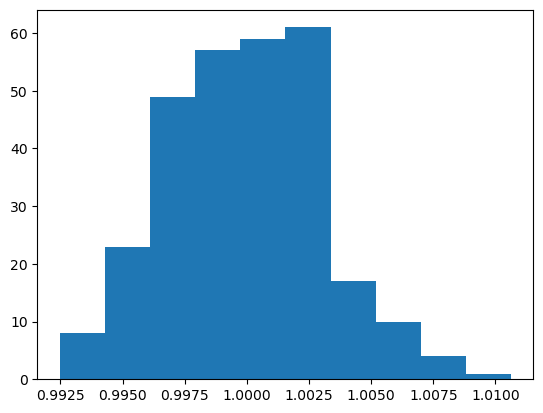

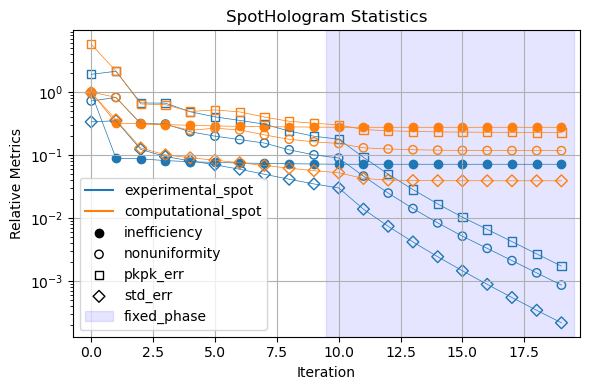

Spot center = (-0.034,-0.012) +/- (0.464,0.617) px
Spot skew = 0.335 +/- 0.409 px


In [38]:
img = cam.get_image()                                        
subimages = analysis.take(img, square, 25)
power = analysis.image_normalization(np.array(subimages, dtype=np.float32))
plt.hist(power / np.mean(power)); plt.show()
hologram.plot_stats()

# Calculate a few statistics
pos = analysis.image_moment(subimages,moment=(1,0)), analysis.image_moment(subimages,moment=(0,1))
print(r"Spot center = (%1.3f,%1.3f) +/- (%1.3f,%1.3f) px"%(np.mean(pos[0]),np.mean(pos[1]),np.var(pos[0]),np.var(pos[1])))
shape = analysis.image_moment(subimages,moment=(1,1))
print(r"Spot skew = %1.3f +/- %1.3f px"%(np.mean(shape),np.var(shape)**0.5))

Not notably. How about perfect wavefront calibration?

In [39]:
slm.phase_correction = -slm.phase_offset
slm.measured_amplitude = slm.amp_profile

In [40]:
#Redo Fourier cal
fs.fourier_calibrate(
    array_shape=[20, 20],           # Size of the calibration grid (Nx, Ny) [knm]
    array_pitch=[20, 20],           # Pitch of the calibration grid (x, y) [knm]
    plot=False)

  0%|          | 0/50 [00:00<?, ?it/s]

{'M': array([[1183.47999603,  859.84672129],
        [-859.84809433, 1183.47584227]]),
 'b': array([[512.00007566],
        [511.99987355]]),
 'a': array([[0.],
        [0.]])}

In [41]:
hologram.reset(reset_flags=True)
hologram.optimize(
    'WGS-Kim',
    maxiter=20,
    feedback='experimental_spot',
    stat_groups=['computational_spot', 'experimental_spot'])

  0%|          | 0/20 [00:00<?, ?it/s]

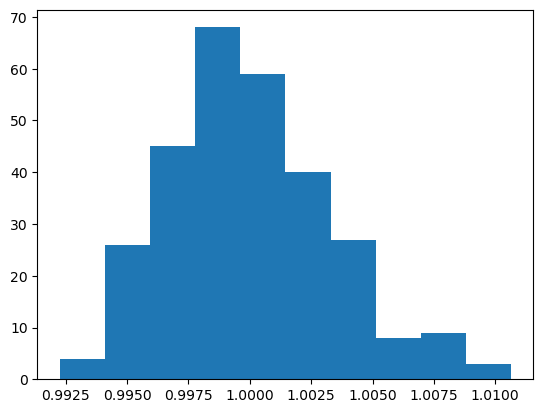

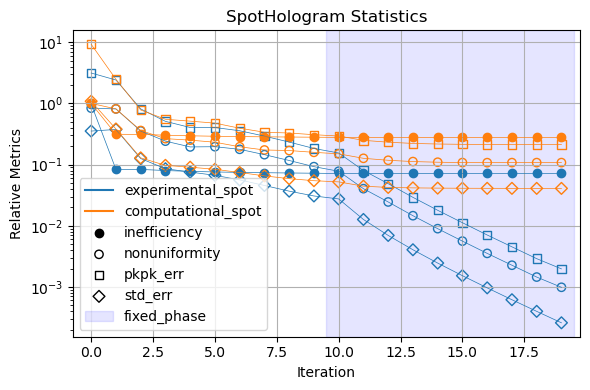

Spot center = (-0.006,0.012) +/- (0.452,0.622) px
Spot skew = 0.352 +/- 0.402 px


In [42]:
img = cam.get_image()                                        
subimages = analysis.take(img, square, 25)
power = analysis.image_normalization(np.array(subimages, dtype=np.float32))
plt.hist(power / np.mean(power)); plt.show()
hologram.plot_stats()

# Calculate a few statistics
pos = analysis.image_moment(subimages,moment=(1,0)), analysis.image_moment(subimages,moment=(0,1))
print(r"Spot center = (%1.3f,%1.3f) +/- (%1.3f,%1.3f) px"%(np.mean(pos[0]),np.mean(pos[1]),np.var(pos[0]),np.var(pos[1])))
shape = analysis.image_moment(subimages,moment=(1,1))
print(r"Spot skew = %1.3f +/- %1.3f px"%(np.mean(shape),np.var(shape)**0.5))

Also not much different. So both wavefront calibration routines work well. Better metrics (e.g. Strehl ratio) are need for a more in-depth analysis of abberation effects. 